# Sonoluminescence

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

# from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA
from hnc.hnc.hnc import Integral_Equation_Solver as IET

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n, P_Ideal_Fermi_Gas, E_Ideal_Fermi_Gas, Gamma, Kappa, ThomasFermiZbar


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

ModuleNotFoundError: No module named 'mendeleev'


# Function for minimizing

In [2]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

@np.vectorize
def symlog(x, linthresh=1):
    if np.abs(x)<=1:
        return x
    else:
        return np.sign(x)*(1 + np.log(np.abs(x)))

@np.vectorize
def unsymlog(symx):
    if np.abs(symx)<=1:
        return symx
    else:
        return np.sign(symx)*(np.exp(np.abs(symx)-1))
    
def solve_least_squares(plasma, sparse_k_array, c_s_k_guess=None):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.c_s_k_matrix

    # Create functions for converting between sparse, not sparse and flattened versions of c_s_k
    # get_sparse_csk = lambda c_s_k: unsymlog(interp1d(plasma.k_array, symlog(c_s_k).flatten())(sparse_k_array))
    # get_csk = lambda sparse_hnc_csk: unsymlog(interp1d(sparse_k_array, symlog(sparse_hnc_csk), kind='cubic')(plasma.k_array))
    get_sparse_csk = lambda c_s_k: interp1d(plasma.k_array, c_s_k.flatten())(sparse_k_array)
    get_csk = lambda sparse_hnc_csk: interp1d(sparse_k_array, sparse_hnc_csk, kind='cubic')(plasma.k_array)
    get_csk_matrix_from_sparse_csk =  lambda sparse_csk: get_csk(sparse_csk)
    
    def min_function(sparse_c_s_k_flat):
        c_s_k_matrix = get_csk_matrix_from_sparse_csk(sparse_c_s_k_flat).reshape(1,1,len(plasma.k_array))
        new_c_s_k_matrix = plasma.guess_c_s_k_matrix(c_s_k_matrix)
        plasma.c_s_k_matrix = new_c_s_k_matrix.copy()
        new_c_s_k_flat = new_c_s_k_matrix
        return sparse_c_s_k_flat - get_sparse_csk(new_c_s_k_flat)
    
    c_s_k_flat_guess = c_s_k_guess
    c_s_k_sparse_guess = get_sparse_csk(c_s_k_flat_guess)
    sol = least_squares(min_function, c_s_k_sparse_guess, verbose=2, ftol=1e-8)#, bounds = c_s_k_bounds)
    plasma.c_s_k_matrix = get_csk_matrix_from_sparse_csk(sol.x).reshape((1,1,len(plasma.k_array)))
    plasma.set_all_matrices_from_csk(plasma.c_s_k_matrix)
    print(sol)
    return sol


# Hard Sphere guess
def Hard_Sphere_c_r(r_array_in_rs, d_in_rs, n_in_rs, verbose=False):
    x_array = r_array_in_rs/d_in_rs
    radius_in_rs = (d_in_rs/2)
    vol_per_particle = n_in_rs
    vol_per_sphere = 4/3*π*radius_in_rs**3
    η = vol_per_sphere / vol_per_particle 
    
    if verbose:
        print(f"Packing fraction: {η}")
    λ1, λ2 = (1+2*η)**2/(1-η)**4, -(2+η)**2/(4*(1-η)**4)
    c_array_r_HS = np.where(x_array<1, -λ1 - 6*η*λ2*x_array - 0.5*η*λ1*x_array**3, 0)
    return c_array_r_HS


def best_HS(plasma, HS_param_guess = None):
    
    
    def min_function(HS_params):
        d_in_rs, n_in_rs = HS_params
        HS_c_r_matrix = Hard_Sphere_c_r(plasma.r_array, d_in_rs, n_in_rs).reshape(1,1,plasma.N_bins)
        HS_c_k_matrix = plasma.FT_r_2_k_matrix(HS_c_r_matrix)
        
        new_c_s_k_matrix = plasma.guess_c_s_k_matrix(HS_c_k_matrix)
        
        return HS_c_k_matrix.flatten() - new_c_s_k_matrix.flatten()
    
    
    sol = least_squares(min_function, HS_param_guess, verbose=0, ftol=1e-8)#, bounds = c_s_k_bounds)
    return sol


From Seth:

#### Ambient Conditions:

Ambient density based upon 293K: is 2.5x10^19/cc, ambient radius [R0] is 4.5um;
total atoms=N= 9.4x109
}
The van der waals radius is a=R0/9.15~.49um.

#### Just before plasma formation:
Minimum bubble size: $\bf{ 1.6\  Angstroms }$
Argon density: $\bf{4.7x10^{21}/cc}$.

Classical uncorrelated random motion temperature: $\bf{~12000K}$.( follows from adiabatic EOS. For these parameters pressure is ~10kbar)


--------------------------

So it would be interesting to see if for these parameters as an initial state DIH and
SCP issues become important for the evolution to the light emitting plasma. If so
this would mean that DIH plays a role in the theory of SL which would be an
important finding. 

In [3]:
name = 'Argon'
Z, A = 18, 40
n_cc = 2.25e22#4.71e21#2.25e22
n_AU = n_cc/cm_to_AU**3
T0_eV = 89.5*K_to_eV#12000*K_to_eV#89.5*K_to_eV#12000*K_to_eV
m_i = m_p*A
Zbar0 = ThomasFermiZbar(Z, n_cc, T0_eV)
rs = rs_from_n(n_cc)*cm_to_AU

# Yukawa Parameters
κ = Kappa(T0_eV*eV_to_AU, n_cc/cm_to_AU**3, Zbar0 )
Γ = Gamma(T0_eV*eV_to_AU, n_cc/cm_to_AU**3, Zbar0 )
print(Γ, κ, Zbar0)


# Argon from <https://doi.org/10.1063/1.479848>
def βu_LJ_126(r, σ, ε ):
    return 4 * ε * ( (σ/r)**12 - (σ/r)**6 ) # r is in terms of WS radius

def βu_LJ_126_CUTOFF(r, σ , ε, cutoff ): # CUTOFF
    r_cutoff= σ*cutoff
    return np.where(r>r_cutoff, βu_LJ_126(r, σ, ε), βu_LJ_126(r_cutoff, σ, ε) ) # r is in terms of WS radius

def βu_LJ_126_CUTOFF(r, σ , ε, cutoff ): # CUTOFF
    pow = 4
    cutoff_r = ( (cutoff*σ)**pow + r**pow  )**(1/pow)
    return 4 * ε * ( (σ/cutoff_r)**12 - (σ/cutoff_r)**6 ) # r is in terms of WS radius

σ_pair = 3.345*Angstrom_to_AU # Angstroms
ε_pair = 125.7*K_to_eV # 125.7 is K, which is a very small number in Joules
βε_pair = 1/T0_eV*ε_pair
βu_r_LJ_func = lambda r, cutoff: βu_LJ_126_CUTOFF(r, σ=σ_pair , ε=βε_pair, cutoff=cutoff )  
Tstar = 1/βε_pair # standard LJ dimensionless number
nstar = n_AU*σ_pair**3#
print(f"T* = {Tstar}")
print(f"n* = {nstar}")

2635.8776891850944 3.5005397087677195 1.7613245625287914
T* = 0.7120127287191726
n* = 0.8421139940625001


In [31]:
n_AU*39.95*amu_to_AU*AU_to_kg/(AU_to_m**3) 

1492.6170521624886

In [29]:
ε_pair*eV_to_AU*AU_to_J

1.735474628080169e-21

In [30]:
σ_pair*AU_to_m

3.345e-10

#### Creating Initial Plasma Object

In [4]:
def LJ_plasma(cutoff, closure='hnc'):
    plasma = IET(1, Γ, 3/(4*π), T0_eV, m_i, oz_method='standard',
        kappa_multiscale = 0, R_max=20.0, N_bins=1000, names=[name], closure=closure, dst_type=3)
    plasma.set_βu_matrix(  np.array([[  βu_r_LJ_func(plasma.r_array*rs, cutoff)  ]])  )
    return plasma 



In [74]:
hnc_list = []
py_list = []

cutoff_list = np.linspace(0.001,0.4,num=5)[::-1]
for i, r_cutoff in enumerate(cutoff_list):
    hnc = LJ_plasma(r_cutoff, closure='hnc')
    py = LJ_plasma(r_cutoff, closure='py')
    
    # Get best HS fit
    HS_fit = best_HS(hnc, [1,1]).x
    print(f"\n\nHard Sphere best parameters: Radius = {HS_fit[0]*rs/σ_pair:0.3f} σ, Density: {HS_fit[1]/rs**3/n_AU:.3f} n")
    HS_c_r_matrix = Hard_Sphere_c_r(hnc.r_array, *HS_fit).reshape(1,1,hnc.N_bins)
    HS_c_k_matrix = hnc.FT_r_2_k_matrix(HS_c_r_matrix)
    
    if i>0: 
        c_s_k_guess_py  = py.c_s_k_matrix.copy()
        c_s_k_guess_hnc = hnc.c_s_k_matrix.copy()
    else:
        c_s_k_guess_py = None#HS_c_k_matrix
        c_s_k_guess_hnc = None#HS_c_k_matrix
    
    solve_least_squares(hnc, np.linspace(hnc.k_array[0], hnc.k_array[-1], num=400), c_s_k_guess = HS_c_k_matrix )
    solve_least_squares(py, np.linspace(py.k_array[0], py.k_array[-1], num=400), c_s_k_guess = HS_c_k_matrix )
    hnc_list.append(hnc)
    py_list.append(py)


/home/zach/plasma/hnc/hnc/hnc.py:533: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)




Hard Sphere best parameters: Radius = 0.854 σ, Density: 8.230 n
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6509e+03                                    1.16e+02    
       1              5         1.0382e+03      1.61e+03       1.07e+01       4.44e+01    
       2              6         4.1469e+02      6.24e+02       1.07e+01       7.05e+01    
       3              8         2.7495e+02      1.40e+02       5.33e+00       1.80e+01    
       4              9         1.4690e+02      1.28e+02       5.33e+00       1.18e+01    
       5             10         4.7472e+01      9.94e+01       1.07e+01       1.04e+01    
       6             12         2.2342e+01      2.51e+01       5.33e+00       1.03e+01    
       7             14         1.6134e+01      6.21e+00       2.67e+00       4.33e+00    
       8             16         1.4059e+01      2.07e+00       1.33e+00       2.31e+00    
       9             17 

### Plot LJ Potentials with different cutoffs

/tmp/ipykernel_581880/3725004090.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('coolwarm')(np.linspace(0,1,num=5))


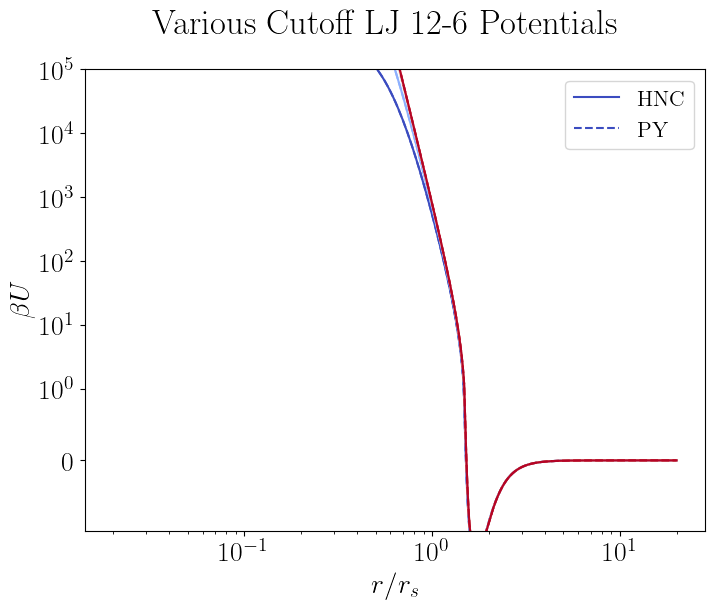

In [75]:
from matplotlib import cm
colors = cm.get_cmap('coolwarm')(np.linspace(0,1,num=5))

fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle("Various Cutoff LJ 12-6 Potentials", fontsize=25)

hnc_label = 'HNC'
py_label  = 'PY'
for i, (hnc, py) in enumerate(zip(hnc_list,py_list)):    
    if i==0:
        ax.plot(hnc.r_array, hnc.βu_r_matrix[0,0],color=colors[i], label=hnc_label )
        ax.plot(py.r_array, py.βu_r_matrix[0,0], '--',  color=colors[i],label=py_label )
    else:
        ax.plot(hnc.r_array, hnc.βu_r_matrix[0,0], color=colors[i])
        ax.plot(py.r_array, py.βu_r_matrix[0,0],'--',   color=colors[i])
    

ax.set_ylim(-1,1e5)
ax.set_xscale('log')
ax.set_yscale('symlog', linthresh=1)

ax.set_ylabel(r"$\beta U $", fontsize=20)
ax.set_xlabel(r"$r/r_s$", fontsize=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=16)


### Direct Correlation Function

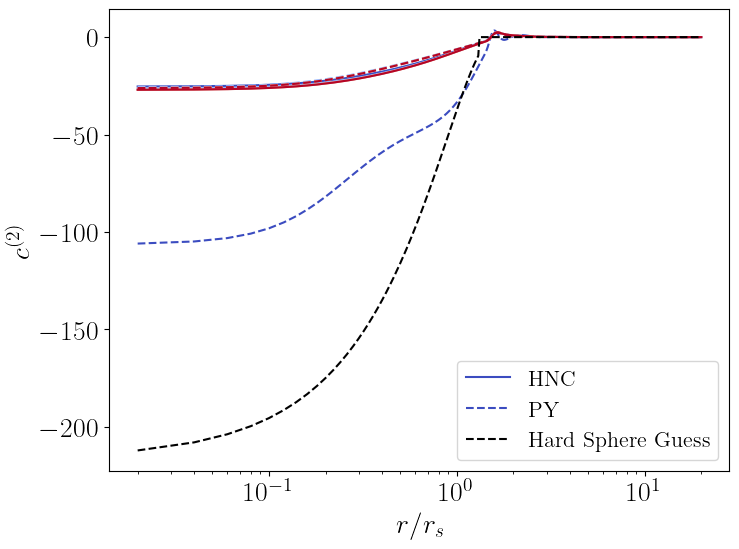

In [76]:
fig, ax = plt.subplots(figsize=(8,6))

for i, (hnc, py) in enumerate(zip(hnc_list,py_list)):    
    if i==0:
        ax.plot(hnc.r_array, hnc.c_r_matrix[0,0],color=colors[i],  label=hnc_label )
        ax.plot(py.r_array, py.c_r_matrix[0,0], '--',color=colors[i], label=py_label )
    else:
        ax.plot(hnc.r_array, hnc.c_r_matrix[0,0],color=colors[i])
        ax.plot(py.r_array, py.c_r_matrix[0,0],'--', color=colors[i])

ax.plot(hnc.r_array, HS_c_r_matrix[0,0] ,'k--', label='Hard Sphere Guess')

# ax.set_ylim(-10,10)
ax.set_xscale('log')
# ax.set_yscale('symlog', linthresh=0.1)

ax.set_ylabel(r"$c^{(2)}$", fontsize=20)
ax.set_xlabel(r"$r/r_s$", fontsize=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=16)

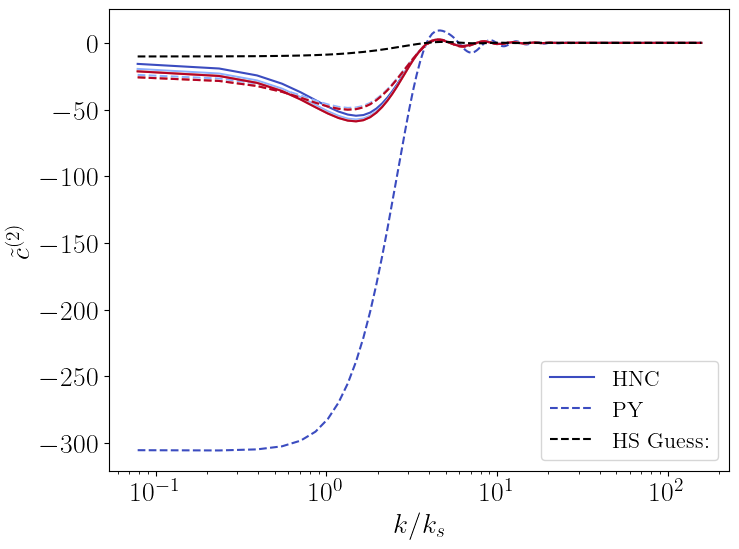

In [77]:
fig, ax = plt.subplots(figsize=(8,6))

for i, (hnc, py) in enumerate(zip(hnc_list,py_list)):    
    if i==0:
        ax.plot(hnc.k_array, hnc.c_k_matrix[0,0],color=colors[i],  label=hnc_label )
        ax.plot(py.k_array, py.c_k_matrix[0,0], '--',color=colors[i], label=py_label )
    else:
        ax.plot(hnc.k_array, hnc.c_k_matrix[0,0],color=colors[i])
        ax.plot(py.k_array, py.c_k_matrix[0,0],'--', color=colors[i])

HS_c_r_matrix = Hard_Sphere_c_r(hnc.r_array, 0.8*σ_pair/rs, 50*3/(4*π)).reshape(1,1,hnc.N_bins)
HS_c_k_matrix = hnc.FT_r_2_k_matrix(HS_c_r_matrix)
ax.plot(hnc.k_array, HS_c_k_matrix[0,0] ,'k--', label='HS Guess: ')

# ax.set_xlim(0,50)
ax.set_xscale('log')
# ax.set_yscale('symlog', linthresh=0.1)

ax.set_ylabel(r"$\tilde{c}^{(2)}$", fontsize=20)
ax.set_xlabel(r"$k/k_s$", fontsize=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=16)

### Radial Distribution Function

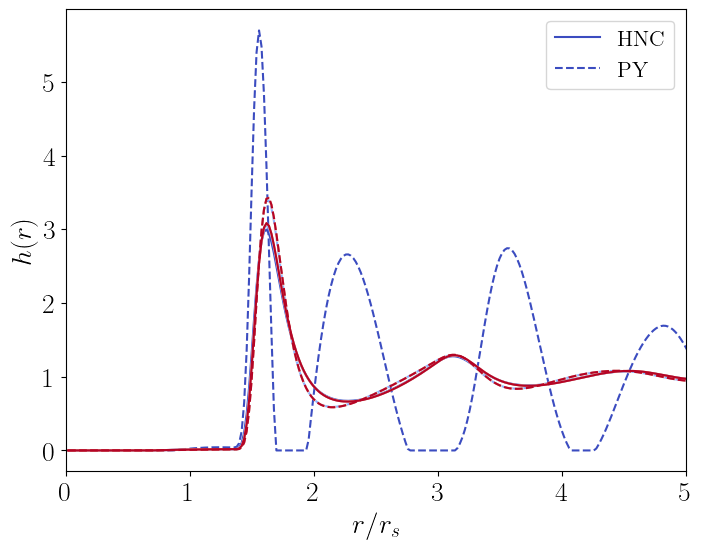

In [78]:
fig, ax = plt.subplots(figsize=(8,6))

for i, (hnc, py) in enumerate(zip(hnc_list,py_list)):    
    if i==0:
        ax.plot(hnc.r_array, hnc.h_r_matrix[0,0]+1, label=hnc_label, color=colors[i] )
        ax.plot(py.r_array, py.h_r_matrix[0,0]+1, '--',label=py_label, color=colors[i] )
    else:
        ax.plot(hnc.r_array, hnc.h_r_matrix[0,0]+1, color=colors[i])
        ax.plot(py.r_array, py.h_r_matrix[0,0]+1,'--', color=colors[i])

ax.set_xlim(0,5)
# ax.set_xscale('log')
# ax.set_yscale('symlog', linthresh=0.1)

ax.set_ylabel(r"$h(r)$", fontsize=20)
ax.set_xlabel(r"$r/r_s$", fontsize=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=16)